<a href="https://colab.research.google.com/github/Bayaniblues/DS-Unit-2-Linear-Models/blob/master/Copy_of_LS_DS_213_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 1, Module 3*

---

# Ridge Regression

## Assignment

We're going back to our other **New York City** real estate dataset. Instead of predicting apartment rents, you'll predict property sales prices.

But not just for condos in Tribeca...

- [?] ? Use a subset of the data where `BUILDING_CLASS_CATEGORY` == `'01 ONE FAMILY DWELLINGS'` and the sale price was more than 100 thousand and less than 2 million.
- [x] Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.
- [x] Do one-hot encoding of categorical features.
- [?] Do feature selection with `SelectKBest`.
- [x] Fit a ridge regression model with multiple features. Use the `normalize=True` parameter (or do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html) beforehand — use the scaler's `fit_transform` method with the train set, and the scaler's `transform` method with the test set)
- [x] Get mean absolute error for the test set
- [ ] As always, commit your notebook to your fork of the GitHub repo.

The [NYC Department of Finance](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page) has a glossary of property sales terms and NYC Building Class Code Descriptions. The data comes from the [NYC OpenData](https://data.cityofnewyork.us/browse?q=NYC%20calendar%20sales) portal.


## Stretch Goals

Don't worry, you aren't expected to do all these stretch goals! These are just ideas to consider and choose from.

- [ ] Add your own stretch goal(s) !
- [ ] Instead of `Ridge`, try `LinearRegression`. Depending on how many features you select, your errors will probably blow up! 💥
- [ ] Instead of `Ridge`, try [`RidgeCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html).
- [ ] Learn more about feature selection:
    - ["Permutation importance"](https://www.kaggle.com/dansbecker/permutation-importance)
    - [scikit-learn's User Guide for Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html)
    - [mlxtend](http://rasbt.github.io/mlxtend/) library
    - scikit-learn-contrib libraries: [boruta_py](https://github.com/scikit-learn-contrib/boruta_py) & [stability-selection](https://github.com/scikit-learn-contrib/stability-selection)
    - [_Feature Engineering and Selection_](http://www.feat.engineering/) by Kuhn & Johnson.
- [ ] Try [statsmodels](https://www.statsmodels.org/stable/index.html) if you’re interested in more inferential statistical approach to linear regression and feature selection, looking at p values and 95% confidence intervals for the coefficients.
- [ ] Read [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf), Chapters 1-3, for more math & theory, but in an accessible, readable way.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'
    
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [0]:
import pandas as pd
import pandas_profiling

# Read New York City property sales data
df = pd.read_csv(DATA_PATH+'condos/NYC_Citywide_Rolling_Calendar_Sales.csv')

# Change column names: replace spaces with underscores
df.columns = [col.replace(' ', '_') for col in df]

# SALE_PRICE was read as strings.
# Remove symbols, convert to integer
df['SALE_PRICE'] = (
    df['SALE_PRICE']
    .str.replace('$','')
    .str.replace('-','')
    .str.replace(',','')
    .astype(int)
)

In [0]:
# BOROUGH is a numeric column, but arguably should be a categorical feature,
# so convert it from a number to a string
df['BOROUGH'] = df['BOROUGH'].astype(str)

In [0]:
# Reduce cardinality for NEIGHBORHOOD feature

# Get a list of the top 10 neighborhoods
top10 = df['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10, 
# replace the neighborhood with 'OTHER'
df.loc[~df['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'

Use a subset of the data where BUILDING_CLASS_CATEGORY == '01 ONE FAMILY DWELLINGS' and the sale price was more than 100 thousand and less than 2 million.

In [0]:
subset = df[df['BUILDING_CLASS_CATEGORY'] =='01 ONE FAMILY DWELLINGS'] 


mask = (subset["SALE_PRICE"] < 100000) & (subset["SALE_PRICE"] > 2000000)

mask
#subset["RANGED_SALE"] = subset.drop([subset["SALE_PRICE"] < 100000])
train = df.loc[subset]


ValueError: ignored

**Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.**

In [0]:
mask = (df['SALE_DATE'] > '01/01/2019') & (df['SALE_DATE'] <= '02/01/2019')
train = df.loc[mask]

train

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
65,1,OTHER,13 CONDOS - ELEVATOR APARTMENTS,2,691,1130,NaN,R4,"505 WEST 19TH STREET, 7D",7D,10011.0,1.0,0.0,1.0,"18,975",1077.0,2013.0,2,R4,2000000,01/02/2019
66,1,OTHER,10 COOPS - ELEVATOR APARTMENTS,2,1347,18,NaN,D4,"345 EAST 54TH ST, 3B",NaN,10022.0,0.0,0.0,0.0,0,0.0,1960.0,2,D4,330000,01/02/2019
67,1,UPPER EAST SIDE (79-96),10 COOPS - ELEVATOR APARTMENTS,2,1491,62,NaN,D4,"16 EAST 80TH STREET, 2A",NaN,10075.0,0.0,0.0,0.0,0,0.0,1925.0,2,D4,600000,01/02/2019
68,1,UPPER EAST SIDE (79-96),13 CONDOS - ELEVATOR APARTMENTS,2,1536,1171,NaN,R4,"1601 3 AVENUE, 17E",17E,10128.0,1.0,0.0,1.0,0,450.0,0.0,2,R4,0,01/02/2019
69,1,UPPER EAST SIDE (79-96),13 CONDOS - ELEVATOR APARTMENTS,2,1554,1116,NaN,R4,"1760 2 AVENUE, 25C",25C,10128.0,1.0,0.0,1.0,0,2047.0,0.0,2,R4,0,01/02/2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6732,5,OTHER,02 TWO FAMILY DWELLINGS,1,225,61,NaN,B2,921 FOREST AVENUE,NaN,10310.0,2.0,0.0,2.0,"4,600",3200.0,1899.0,1,B2,10,02/01/2019
6733,5,OTHER,01 ONE FAMILY DWELLINGS,1,1462,10,NaN,A9,131 GLASCOE AVENUE,NaN,10314.0,1.0,0.0,1.0,"2,160",1184.0,1960.0,1,A9,459000,02/01/2019
6734,5,OTHER,01 ONE FAMILY DWELLINGS,1,1462,11,NaN,A9,129 GLASCOE AVENUE,NaN,10314.0,1.0,0.0,1.0,"2,160",1184.0,1960.0,1,A9,0,02/01/2019
6735,5,OTHER,02 TWO FAMILY DWELLINGS,1,391,483,NaN,B2,41 NORTH AVENUE,NaN,10302.0,2.0,0.0,2.0,"5,775",3180.0,1975.0,1,B2,0,02/01/2019


In [0]:
maskt = (df['SALE_DATE'] >= '03/01/2019')
test = df.loc[maskt]

test

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
12062,1,OTHER,09 COOPS - WALKUP APARTMENTS,2,719,36,NaN,C6,"405 WEST 21ST STREET, 2R",NaN,10011.0,0.0,0.0,0.0,0,0.0,1900.0,2,C6,750000,03/01/2019
12063,1,OTHER,13 CONDOS - ELEVATOR APARTMENTS,2,766,1152,NaN,R4,"270 WEST 17TH, 4K",4K,10011.0,1.0,0.0,1.0,0,585.0,1989.0,2,R4,945000,03/01/2019
12064,1,OTHER,13 CONDOS - ELEVATOR APARTMENTS,2,153,1107,NaN,R4,"4951 CHAMBERS STREET, 9A",9A,10007.0,1.0,0.0,1.0,"18,919",231379.0,1910.0,2,R4,3400000,03/01/2019
12065,1,OTHER,13 CONDOS - ELEVATOR APARTMENTS,2,439,1041,NaN,R4,"438 EAST 12TH STREET, 4F",4F,10009.0,1.0,0.0,1.0,"29,705",1686.0,2015.0,2,R4,3426116,03/01/2019
12066,1,GRAMERCY,13 CONDOS - ELEVATOR APARTMENTS,2,882,1260,NaN,R4,"88 LEXINGTON AVENUE, 1201",1201,10016.0,1.0,0.0,1.0,"11,282",1932.0,1927.0,2,R4,3778516,03/01/2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23035,4,OTHER,01 ONE FAMILY DWELLINGS,1,10965,276,NaN,A5,111-17 FRANCIS LEWIS BLVD,NaN,11429.0,1.0,0.0,1.0,"1,800",1224.0,1945.0,1,A5,510000,04/30/2019
23036,4,OTHER,09 COOPS - WALKUP APARTMENTS,2,169,29,NaN,C6,"45-14 43RD STREET, 3C",NaN,11104.0,0.0,0.0,0.0,0,0.0,1929.0,2,C6,355000,04/30/2019
23037,4,OTHER,10 COOPS - ELEVATOR APARTMENTS,2,131,4,NaN,D4,"50-05 43RD AVENUE, 3M",NaN,11377.0,0.0,0.0,0.0,0,0.0,1932.0,2,D4,375000,04/30/2019
23038,4,OTHER,02 TWO FAMILY DWELLINGS,1,8932,18,NaN,S2,91-10 JAMAICA AVE,NaN,11421.0,2.0,1.0,3.0,"2,078",2200.0,1931.0,1,S2,1100000,04/30/2019


In [0]:
target  = 'SALE_PRICE'
y_train = train[target]
y_test  = test[target]
guess = y_train.mean()
guess

1354943.382643885

In [0]:
def test_error(X, header):
  from sklearn.metrics import mean_absolute_error
  y_pred = [guess] * len(X)
  mae    = mean_absolute_error(X, y_pred)
  return print(f'{header} is {mae:.2f}')

test_error(y_train, "Train error")

test_error(y_test, "Test error")

Train error is 1717829.33
Test error is 1588414.51


### Hot encoding
LAND_SQUARE_FEET


In [0]:
train

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
65,1,OTHER,13 CONDOS - ELEVATOR APARTMENTS,2,691,1130,NaN,R4,"505 WEST 19TH STREET, 7D",7D,10011.0,1.0,0.0,1.0,"18,975",1077.0,2013.0,2,R4,2000000,01/02/2019
66,1,OTHER,10 COOPS - ELEVATOR APARTMENTS,2,1347,18,NaN,D4,"345 EAST 54TH ST, 3B",NaN,10022.0,0.0,0.0,0.0,0,0.0,1960.0,2,D4,330000,01/02/2019
67,1,UPPER EAST SIDE (79-96),10 COOPS - ELEVATOR APARTMENTS,2,1491,62,NaN,D4,"16 EAST 80TH STREET, 2A",NaN,10075.0,0.0,0.0,0.0,0,0.0,1925.0,2,D4,600000,01/02/2019
68,1,UPPER EAST SIDE (79-96),13 CONDOS - ELEVATOR APARTMENTS,2,1536,1171,NaN,R4,"1601 3 AVENUE, 17E",17E,10128.0,1.0,0.0,1.0,0,450.0,0.0,2,R4,0,01/02/2019
69,1,UPPER EAST SIDE (79-96),13 CONDOS - ELEVATOR APARTMENTS,2,1554,1116,NaN,R4,"1760 2 AVENUE, 25C",25C,10128.0,1.0,0.0,1.0,0,2047.0,0.0,2,R4,0,01/02/2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6732,5,OTHER,02 TWO FAMILY DWELLINGS,1,225,61,NaN,B2,921 FOREST AVENUE,NaN,10310.0,2.0,0.0,2.0,"4,600",3200.0,1899.0,1,B2,10,02/01/2019
6733,5,OTHER,01 ONE FAMILY DWELLINGS,1,1462,10,NaN,A9,131 GLASCOE AVENUE,NaN,10314.0,1.0,0.0,1.0,"2,160",1184.0,1960.0,1,A9,459000,02/01/2019
6734,5,OTHER,01 ONE FAMILY DWELLINGS,1,1462,11,NaN,A9,129 GLASCOE AVENUE,NaN,10314.0,1.0,0.0,1.0,"2,160",1184.0,1960.0,1,A9,0,02/01/2019
6735,5,OTHER,02 TWO FAMILY DWELLINGS,1,391,483,NaN,B2,41 NORTH AVENUE,NaN,10302.0,2.0,0.0,2.0,"5,775",3180.0,1975.0,1,B2,0,02/01/2019


In [0]:
target = 'SALE_PRICE'
high_cardinality = ['ADDRESS', 'BUILDING_CLASS_CATEGORY', 'NEIGHBORHOOD', 'SALE_DATE']
features = train.columns.drop([target] + high_cardinality)
features


Index(['BOROUGH', 'TAX_CLASS_AT_PRESENT', 'BLOCK', 'LOT', 'EASE-MENT',
       'BUILDING_CLASS_AT_PRESENT', 'APARTMENT_NUMBER', 'ZIP_CODE',
       'RESIDENTIAL_UNITS', 'COMMERCIAL_UNITS', 'TOTAL_UNITS',
       'LAND_SQUARE_FEET', 'GROSS_SQUARE_FEET', 'YEAR_BUILT',
       'TAX_CLASS_AT_TIME_OF_SALE', 'BUILDING_CLASS_AT_TIME_OF_SALE'],
      dtype='object')

In [0]:
X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

In [0]:
# b4 encoding
X_train

,BOROUGH,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE
65,1,2,691,1130,NaN,R4,7D,10011.0,1.0,0.0,1.0,"18,975",1077.0,2013.0,2,R4
66,1,2,1347,18,NaN,D4,NaN,10022.0,0.0,0.0,0.0,0,0.0,1960.0,2,D4
67,1,2,1491,62,NaN,D4,NaN,10075.0,0.0,0.0,0.0,0,0.0,1925.0,2,D4
68,1,2,1536,1171,NaN,R4,17E,10128.0,1.0,0.0,1.0,0,450.0,0.0,2,R4
69,1,2,1554,1116,NaN,R4,25C,10128.0,1.0,0.0,1.0,0,2047.0,0.0,2,R4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6732,5,1,225,61,NaN,B2,NaN,10310.0,2.0,0.0,2.0,"4,600",3200.0,1899.0,1,B2
6733,5,1,1462,10,NaN,A9,NaN,10314.0,1.0,0.0,1.0,"2,160",1184.0,1960.0,1,A9
6734,5,1,1462,11,NaN,A9,NaN,10314.0,1.0,0.0,1.0,"2,160",1184.0,1960.0,1,A9
6735,5,1,391,483,NaN,B2,NaN,10302.0,2.0,0.0,2.0,"5,775",3180.0,1975.0,1,B2


In [0]:
import category_encoders as ce
encoder = ce.OneHotEncoder(use_cat_names=True)
X_train = encoder.fit_transform(X_train)

In [0]:
X_train

,BOROUGH_1,BOROUGH_2,BOROUGH_3,BOROUGH_4,BOROUGH_5,TAX_CLASS_AT_PRESENT_2,TAX_CLASS_AT_PRESENT_1,TAX_CLASS_AT_PRESENT_4,TAX_CLASS_AT_PRESENT_2A,TAX_CLASS_AT_PRESENT_2B,TAX_CLASS_AT_PRESENT_1B,TAX_CLASS_AT_PRESENT_1A,TAX_CLASS_AT_PRESENT_2C,TAX_CLASS_AT_PRESENT_1C,TAX_CLASS_AT_PRESENT_1D,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT_R4,BUILDING_CLASS_AT_PRESENT_D4,BUILDING_CLASS_AT_PRESENT_B2,BUILDING_CLASS_AT_PRESENT_C7,BUILDING_CLASS_AT_PRESENT_A1,BUILDING_CLASS_AT_PRESENT_C0,BUILDING_CLASS_AT_PRESENT_B1,BUILDING_CLASS_AT_PRESENT_Z9,BUILDING_CLASS_AT_PRESENT_A5,BUILDING_CLASS_AT_PRESENT_B3,BUILDING_CLASS_AT_PRESENT_D6,BUILDING_CLASS_AT_PRESENT_S3,BUILDING_CLASS_AT_PRESENT_C1,BUILDING_CLASS_AT_PRESENT_S2,BUILDING_CLASS_AT_PRESENT_C2,BUILDING_CLASS_AT_PRESENT_RP,BUILDING_CLASS_AT_PRESENT_C3,BUILDING_CLASS_AT_PRESENT_RS,BUILDING_CLASS_AT_PRESENT_A2,BUILDING_CLASS_AT_PRESENT_R2,BUILDING_CLASS_AT_PRESENT_V0,BUILDING_CLASS_AT_PRESENT_A0,...,BUILDING_CLASS_AT_TIME_OF_SALE_O6,BUILDING_CLASS_AT_TIME_OF_SALE_H1,BUILDING_CLASS_AT_TIME_OF_SALE_O7,BUILDING_CLASS_AT_TIME_OF_SALE_O5,BUILDING_CLASS_AT_TIME_OF_SALE_S4,BUILDING_CLASS_AT_TIME_OF_SALE_J1,BUILDING_CLASS_AT_TIME_OF_SALE_G6,BUILDING_CLASS_AT_TIME_OF_SALE_M1,BUILDING_CLASS_AT_TIME_OF_SALE_D9,BUILDING_CLASS_AT_TIME_OF_SALE_G3,BUILDING_CLASS_AT_TIME_OF_SALE_J6,BUILDING_CLASS_AT_TIME_OF_SALE_O2,BUILDING_CLASS_AT_TIME_OF_SALE_W2,BUILDING_CLASS_AT_TIME_OF_SALE_R7,BUILDING_CLASS_AT_TIME_OF_SALE_GW,BUILDING_CLASS_AT_TIME_OF_SALE_K9,BUILDING_CLASS_AT_TIME_OF_SALE_C9,BUILDING_CLASS_AT_TIME_OF_SALE_D3,BUILDING_CLASS_AT_TIME_OF_SALE_F1,BUILDING_CLASS_AT_TIME_OF_SALE_K7,BUILDING_CLASS_AT_TIME_OF_SALE_RW,BUILDING_CLASS_AT_TIME_OF_SALE_W9,BUILDING_CLASS_AT_TIME_OF_SALE_J2,BUILDING_CLASS_AT_TIME_OF_SALE_O8,BUILDING_CLASS_AT_TIME_OF_SALE_O1,BUILDING_CLASS_AT_TIME_OF_SALE_F4,BUILDING_CLASS_AT_TIME_OF_SALE_D2,BUILDING_CLASS_AT_TIME_OF_SALE_K5,BUILDING_CLASS_AT_TIME_OF_SALE_F8,BUILDING_CLASS_AT_TIME_OF_SALE_R8,BUILDING_CLASS_AT_TIME_OF_SALE_M9,BUILDING_CLASS_AT_TIME_OF_SALE_RR,BUILDING_CLASS_AT_TIME_OF_SALE_Q9,BUILDING_CLASS_AT_TIME_OF_SALE_M3,BUILDING_CLASS_AT_TIME_OF_SALE_S0,BUILDING_CLASS_AT_TIME_OF_SALE_Z2,BUILDING_CLASS_AT_TIME_OF_SALE_L9,BUILDING_CLASS_AT_TIME_OF_SALE_E7,BUILDING_CLASS_AT_TIME_OF_SALE_D8,BUILDING_CLASS_AT_TIME_OF_SALE_J9
65,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,691,1130,NaN,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
66,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1347,18,NaN,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
67,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1491,62,NaN,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
68,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1536,1171,NaN,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
69,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1554,1116,NaN,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6732,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,225,61,NaN,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6733,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1462,10,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6734,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1462,11,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [0]:
X_test = encoder.transform(X_test)
X_test

ValueError: ignored

###Ridge regression


In [0]:
# make an X_test

In [0]:
from IPython.display import display, HTML

for alpha in [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]:
    
    # Fit Ridge Regression model
    feature = 'SALE_PRICE'
    display(HTML(f'Ridge Regression, with alpha={alpha}'))
    model = Ridge(alpha=alpha, normalize=True)
    model.fit(X_train[[feature]], y_train)
    
    # Get Test MAE
    y_pred = model.predict(X_test[[feature]])
    mae = mean_absolute_error(y_test, y_pred)
    display(HTML(f'Test Mean Absolute Error: ${mae:,.0f}'))
    
    train.plot.scatter(feature, target, alpha=0.05)
    plt.plot(X_test[feature], y_pred)
    plt.show()

KeyError: ignored

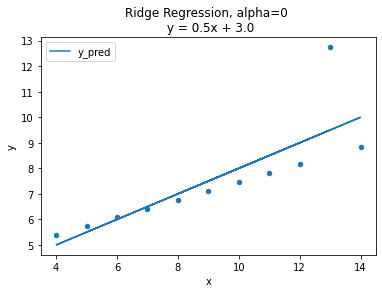

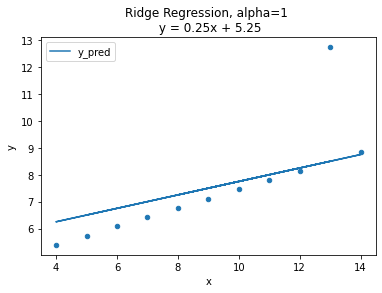

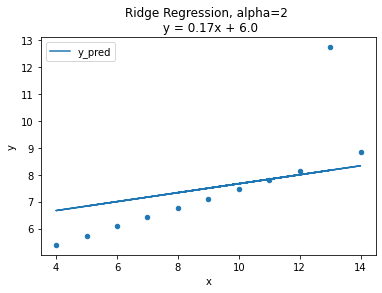

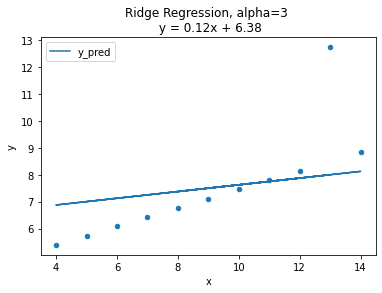

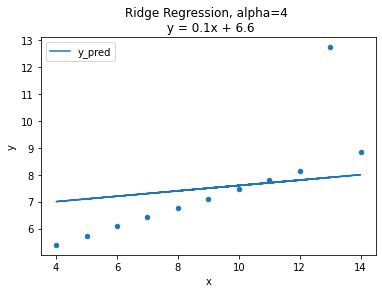

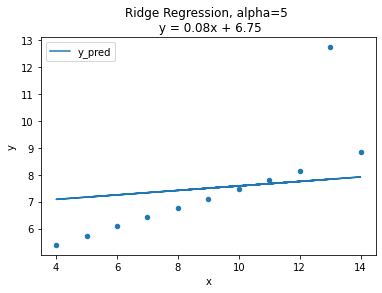

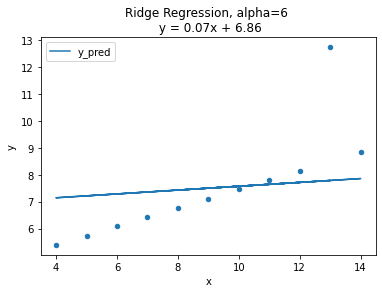

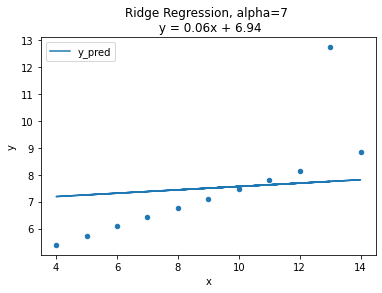

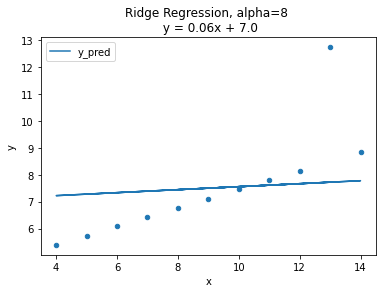

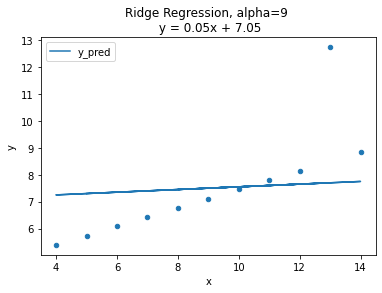

In [0]:
%matplotlib inline

import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge

def ridge_anscombe(alpha):
    """
    Fit & plot a ridge regression model,
    with Anscombe Quartet dataset III.

    alpha : positive float, regularization strength
    """

    # Load data
    anscombe = sns.load_dataset('anscombe').query('dataset=="III"')

    # Plot data
    ax = anscombe.plot.scatter('x', 'y')

    # Fit linear model
    ridge = Ridge(alpha=alpha, normalize=True)
    ridge.fit(anscombe[['x']], anscombe['y'])

    # Get linear equation
    m = ridge.coef_[0].round(2)
    b = ridge.intercept_.round(2)
    title = f'Ridge Regression, alpha={alpha} \n y = {m}x + {b}'

    # Get predictions
    anscombe['y_pred'] = ridge.predict(anscombe[['x']])

    # Plot predictions
    anscombe.plot('x', 'y_pred', ax=ax, title=title)
    plt.show()
    
    
for alpha in range(10):
    ridge_anscombe(alpha=alpha)